In [24]:
import re
import spacy
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from string import punctuation
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [25]:
import nltk
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to C:\Users\Dicky
[nltk_data]    |     Zulfikar\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to C:\Users\Dicky
[nltk_data]    |     Zulfikar\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Dicky
[nltk_data]    |     Zulfikar\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Dicky
[nltk_data]    |     Zulfikar\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_t

True

In [26]:
df = pd.read_csv('sampled_data.csv')
df.head()

,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url
0,3253,thanks..... .................................,4,elektronik,Rexco 18 Contact Cleaner / Pembersih Komponen ...,184464874,29,2100844,https://www.tokopedia.com/miniperkakas/rexco-1...
1,3559,oke barang sudah di terima dengan baik...,4,elektronik,Alfalink EI 428 - Kamus Elektronik Electronic ...,24896339,283,588756,https://www.tokopedia.com/omegaelectronic/alfa...
2,3131,"brg udh dtg #pontianak dgn slmat gan, mksih..",5,elektronik,Alfalink EI 212 - Kamus Elektronik,20602038,383,588756,https://www.tokopedia.com/omegaelectronic/alfa...
3,3658,Cepat dan tepat! Recommended seller,5,elektronik,TI-84 Plus CE,38187136,53,844505,https://www.tokopedia.com/datasempoa/ti-84-plu...
4,3252,"mantaf,. langsung test.. residu hilang\nkirima...",4,elektronik,Rexco 18 Contact Cleaner / Pembersih Komponen ...,184464874,29,2100844,https://www.tokopedia.com/miniperkakas/rexco-1...


In [27]:
print(df['category'].value_counts())

category
elektronik     1000
fashion        1000
olahraga       1000
handphone      1000
pertukangan    1000
Name: count, dtype: int64


# Pre-Processing

In [28]:
df = df.drop(columns=['Unnamed: 0', 'product_id', 'shop_id', 'sold', 'product_url'])
df

,text,rating,category,product_name
0,thanks..... .................................,4,elektronik,Rexco 18 Contact Cleaner / Pembersih Komponen ...
1,oke barang sudah di terima dengan baik...,4,elektronik,Alfalink EI 428 - Kamus Elektronik Electronic ...
2,"brg udh dtg #pontianak dgn slmat gan, mksih..",5,elektronik,Alfalink EI 212 - Kamus Elektronik
3,Cepat dan tepat! Recommended seller,5,elektronik,TI-84 Plus CE
4,"mantaf,. langsung test.. residu hilang\nkirima...",4,elektronik,Rexco 18 Contact Cleaner / Pembersih Komponen ...
...,...,...,...,...
4995,Trims gan paket telah di terima .,4,pertukangan,Staples Gun Tacker Mollar 3 in 1 / Staple Jok ...
4996,terimakasih pengiriman cepat.....................,5,pertukangan,staples tembak HOMASTER / steples tembak / sta...
4997,terima kasih n maaf baru konfirmasi..,5,pertukangan,staples tembak homaster / staple gun
4998,Terima kasih packing rapi,4,pertukangan,staples tembak staple gun tacker staples jok m...


In [29]:
slang_df = pd.read_csv("slang_dict.csv", sep=';')
slang_dict = pd.Series(slang_df['baku'].values, index=slang_df['slang'].values).to_dict()

def replace_slang(text, slang_dict):
    words = text.split()
    new_text = ' '.join([slang_dict[word] if word in slang_dict else word for word in words])
    return new_text

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\&\w*;", "", text)  # Menghapus HTML entities
    text = re.sub(r"@[^\s]+", "", text)  # Menghapus mention @
    text = re.sub(r"\$\w*", "", text)  # Menghapus simbol uang
    text = re.sub(r"https?:\/\/.*\/\w*", "", text)  # Menghapus URL
    text = re.sub(r"#\w*", "", text)  # Menghapus hashtag
    text = re.sub(r"\b\w{1,2}\b", "", text)  # Menghapus kata pendek
    text = re.sub(r"\s+", " ", text).strip()  # Normalisasi spasi
    text = "".join(c for c in text if c <= "\uFFFF")  # Menghapus karakter tidak valid
    text = replace_slang(text, slang_dict) # Penggantian slang

    # Penghapusan stopwords
    stop_words = set(stopwords.words('indonesian'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

df['cleaned_text'] = df['text'].apply(preprocess_text)
data = df.drop_duplicates(subset='cleaned_text')
df


,text,rating,category,product_name,cleaned_text
0,thanks..... .................................,4,elektronik,Rexco 18 Contact Cleaner / Pembersih Komponen ...,thanks
1,oke barang sudah di terima dengan baik...,4,elektronik,Alfalink EI 428 - Kamus Elektronik Electronic ...,oke barang terima baik
2,"brg udh dtg #pontianak dgn slmat gan, mksih..",5,elektronik,Alfalink EI 212 - Kamus Elektronik,barang selamat gan mksih
3,Cepat dan tepat! Recommended seller,5,elektronik,TI-84 Plus CE,cepat tepat recommended seller
4,"mantaf,. langsung test.. residu hilang\nkirima...",4,elektronik,Rexco 18 Contact Cleaner / Pembersih Komponen ...,mantaf langsung test residu hilang kirim lamba...
...,...,...,...,...,...
4995,Trims gan paket telah di terima .,4,pertukangan,Staples Gun Tacker Mollar 3 in 1 / Staple Jok ...,terima kasih kawan paket terima
4996,terimakasih pengiriman cepat.....................,5,pertukangan,staples tembak HOMASTER / steples tembak / sta...,terimakasih kirim cepat dan barang sesuai
4997,terima kasih n maaf baru konfirmasi..,5,pertukangan,staples tembak homaster / staple gun,terima kasih maaf konfirmasi
4998,Terima kasih packing rapi,4,pertukangan,staples tembak staple gun tacker staples jok m...,terima kasih packing rapi


-------

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4996 entries, 0 to 4995
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          4996 non-null   object
 1   rating        4996 non-null   int64 
 2   category      4996 non-null   object
 3   product_name  4996 non-null   object
 4   cleaned_text  4955 non-null   object
 5   label         4996 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.3+ KB


In [81]:
# Cek baris yang memiliki NaN di cleaned_text
nan_rows = df[df['cleaned_text'].isna()]
print(nan_rows[['text', 'cleaned_text']])


                                                   text cleaned_text
376      **********************************************          NaN
440   ok...............................................          NaN
482                           *************************          NaN
980   .................................................          NaN
1107                  .................................          NaN
1164                   👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍👍          NaN
1547                          Ada 1 bagian yg tidak ada          NaN
1558                                         👍👍👍👍👍👍👍👍👍👍          NaN
1686                        ok...…………………………………………………...          NaN
1766                             ......................          NaN
1798                            ok...........,.,.......          NaN
1841  .................................................          NaN
2040                             Ok....................          NaN
2057              Ok              

In [93]:
df = df.dropna(subset=['cleaned_text'])
df.isnull().sum()

text            0
rating          0
category        0
product_name    0
cleaned_text    0
label           0
dtype: int64

# Klasifikasi Sentimen

1. Pelabelan Manual

In [96]:
positive_words = ["gak kecewa", "sip", "cepat", "suka", "mantab", "mantul", "good", "recomended", "thank you", "makasih", "aman", "rapi", "fast", "thanks", "barang", "sesuai", "cepae", "bagus", "sudah", "sampai", "terima", "excellent", "baik", "mantap", "puas", "terima kasih", "murah", "recommended", "aman", "bersih", "original", "rapi", "mulus", "cocok", "nyaman", "terpercaya", "top", "sip", "selamat", "oke"]
negative_words = ["cacat", "tidak", "kurang", "rusak", "salah", "lama", "terlambat", "jelek", "cacat", "kecewa", "penipuan", "palsu", "buruk", "lelet", "kotor", "hancur", "lambat", "menyesal", "tidak sesuai", "bohong", "residu", "disayangkan", "trouble", "mengecewakan"]

def label_sentiment(text):
    if isinstance(text, str):
        pos_count = sum(1 for word in positive_words if word in text)
        neg_count = sum(1 for word in negative_words if word in text)
        
        if pos_count > neg_count:
            return 'positive'
        elif neg_count > pos_count:
            return 'negative'
        else:
            return 'neutral'
    else:
        return 'neutral'  

df['label'] = df['cleaned_text'].apply(label_sentiment)
df.sample(5)

,text,rating,category,product_name,cleaned_text,label
2678,Bagus..nunggu pengiriman kedua semoga cepat sa...,4,olahraga,Handwrap Bandage 4.5 mtr Muay Thai MMA Boxing ...,bagus nunggu kirim moga cepat,positive
64,Pengiriman cepat respon juga cepat,5,elektronik,Alfalink EI 16 S - Kamus Elektronik,kirim cepat respon cepat,positive
3318,Pngriman cpt.\nPacking rapih.\nTerimakasih,5,handphone,SPEAKER BLUETOOTH JBL G2 SPEAKER WIRELESS MINI...,pngriman cpt packing rapih terimakasih,positive
1374,gpp dah sya butuh cepat kmarin pdahal\n.. cuma...,4,fashion,Sepatu Sekolah Nike Roshe Run Full Hitam Anak ...,gpp dah sya butuh cepat kmarin pdahal,positive
4411,joooooooooooooooooooooooosss,5,pertukangan,Isi Staples / Gun Tacker 13/8 Ukuran 8 mm Harg...,joooooooooooooooooooooooosss,neutral


In [97]:
sentiment_counts = df['label'].value_counts()
print(sentiment_counts)

label
positive    4366
neutral      531
negative      58
Name: count, dtype: int64


In [98]:
df.to_excel('data_cleaned.xlsx', index=False)

In [99]:
df = pd.read_excel('data_cleaned.xlsx')

Memisahkan Fitur dan Target

In [100]:
X = df['cleaned_text'] 
y = df['label']

Split Data

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

TF-IDF Vectorization

In [102]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Model Naive Bayes

In [103]:
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)
y_pred_nb = model_nb.predict(X_test_tfidf)

print("Classification Report for Naive Bayes:")
print(classification_report(y_test, y_pred_nb))

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         9
     neutral       1.00      0.04      0.07       107
    positive       0.89      1.00      0.94       875

    accuracy                           0.89       991
   macro avg       0.63      0.35      0.34       991
weighted avg       0.89      0.89      0.84       991



c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

Model Support Vector Machine (SVM)

In [104]:
from sklearn import svm
from sklearn.pipeline import make_pipeline

model_svm = svm.SVC(kernel='linear')
model_svm.fit(X_train_tfidf, y_train)
y_pred_svm = model_svm.predict(X_test_tfidf)

print("Classification Report for SVM:")
print(classification_report(y_test, y_pred_svm))

Classification Report for SVM:
              precision    recall  f1-score   support

    negative       0.33      0.11      0.17         9
     neutral       0.85      0.60      0.70       107
    positive       0.95      0.99      0.97       875

    accuracy                           0.94       991
   macro avg       0.71      0.57      0.61       991
weighted avg       0.93      0.94      0.93       991



Model Random Forest

In [105]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

Classification Report for Random Forest:
              precision    recall  f1-score   support

    negative       0.50      0.11      0.18         9
     neutral       0.77      0.72      0.74       107
    positive       0.96      0.98      0.97       875

    accuracy                           0.94       991
   macro avg       0.74      0.60      0.63       991
weighted avg       0.94      0.94      0.94       991



Model Regresi Logistik

In [106]:
model_logistic = LogisticRegression(max_iter=1000)
model_logistic.fit(X_train_tfidf, y_train)
y_pred_logistic = model_logistic.predict(X_test_tfidf)

print("Classification Report for Regresi Logistik:")
print(classification_report(y_test, y_pred_logistic))

Classification Report for Regresi Logistik:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         9
     neutral       1.00      0.19      0.31       107
    positive       0.90      1.00      0.95       875

    accuracy                           0.90       991
   macro avg       0.63      0.40      0.42       991
weighted avg       0.90      0.90      0.87       991



c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

Model Decision Tree

In [107]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier()
model_tree.fit(X_train_tfidf, y_train)
y_pred_tree = model_tree.predict(X_test_tfidf)

print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_tree))

Classification Report for Decision Tree:
              precision    recall  f1-score   support

    negative       0.50      0.44      0.47         9
     neutral       0.82      0.82      0.82       107
    positive       0.98      0.98      0.98       875

    accuracy                           0.96       991
   macro avg       0.77      0.75      0.76       991
weighted avg       0.96      0.96      0.96       991



Validasi Silang (Cross-Validation)

In [108]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Membuat pipeline untuk setiap model
models = {
    "Naive Bayes": Pipeline([('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())]),
    "SVM": Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC())]),
    "Logistic Regression": Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression(max_iter=1000))]),
    "Decision Tree": Pipeline([('tfidf', TfidfVectorizer()), ('clf', DecisionTreeClassifier())]),
}

# Melakukan cross-validation untuk setiap model
for name, model in models.items():
    cv_scores = cross_val_score(model, df['cleaned_text'], df['label'], cv=5)
    cv_scores_formatted = [f"{score:.2f}" for score in cv_scores] 
    print(f"{name} Cross-validation scores: {cv_scores_formatted}")
    print(f"{name} Mean Cross-validation score: {cv_scores.mean():.2f}\n") 

Naive Bayes Cross-validation scores: ['0.89', '0.88', '0.89', '0.88', '0.89']
Naive Bayes Mean Cross-validation score: 0.89

SVM Cross-validation scores: ['0.90', '0.90', '0.90', '0.90', '0.90']
SVM Mean Cross-validation score: 0.90

Logistic Regression Cross-validation scores: ['0.90', '0.91', '0.91', '0.91', '0.91']
Logistic Regression Mean Cross-validation score: 0.91

Decision Tree Cross-validation scores: ['0.96', '0.96', '0.96', '0.96', '0.97']
Decision Tree Mean Cross-validation score: 0.96



Memisahkan Review Positif dan Negatif

In [109]:
positive = df[df['label'] == 'positive']
negative = df[df['label'] == 'negative']
neutral = df[df['label'] == 'neutral']

Menggabungkan Teks Review Positif dan Negatif

In [110]:
positive_text = ' '.join(positive['cleaned_text'])
negative_text = ' '.join(negative['cleaned_text'])
neutral_text = ' '.join(neutral['cleaned_text'])

In [111]:
positive_reviews = pd.DataFrame({'Review': positive['cleaned_text'], 'Sentiment': 'Positive'})
negative_reviews = pd.DataFrame({'Review': negative['cleaned_text'], 'Sentiment': 'Negative'})
neutral_reviews = pd.DataFrame({'Review': neutral['cleaned_text'], 'Sentiment': 'Neutral'})

In [112]:
positive_reviews

,Review,Sentiment
0,thanks,Positive
1,oke barang terima baik,Positive
2,barang selamat gan mksih,Positive
3,cepat tepat recommended seller,Positive
5,barang cepst sampe paking bsgus,Positive
...,...,...
4950,terima kasih kawan paket terima,Positive
4951,terimakasih kirim cepat dan barang sesuai,Positive
4952,terima kasih maaf konfirmasi,Positive
4953,terima kasih packing rapi,Positive


In [114]:
negative_reviews.sample(7)

,Review,Sentiment
2794,kualitas kurang retas,Negative
3973,kecewa dipakey isiya kluar buah papan nggak ne...,Negative
1455,saya kecewa sistem kerja kirim jasa kirim nya ...,Negative
3036,kualitas buruk harga kualitas,Negative
3589,produk awet solid kecewa,Negative
3633,barang selamat cacat ukur kira huawei nova si...,Negative
1952,paket tdk kecewa skl,Negative


In [115]:
neutral_reviews

,Review,Sentiment
13,bagus produk sayang system kirim send trouble ...,Neutral
15,alfalinknya kecil imut2,Neutral
22,danke gan,Neutral
23,pas warna pink kecewa thanks,Neutral
26,yaah harga 10ribuan lumayan laah jangkau mudah...,Neutral
...,...,...
4892,nyampe jam transaksi udah nyampe rumah mksh,Neutral
4893,gagal,Neutral
4900,biar bintang bicara thank,Neutral
4902,masang jok gak pake,Neutral


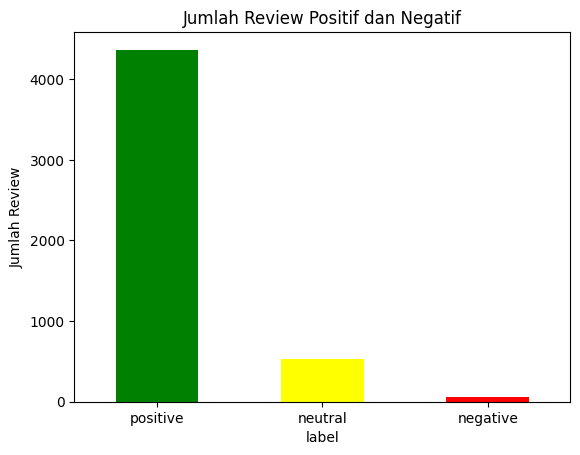

In [116]:
sentiment_counts = df['label'].value_counts()
sentiment_counts.plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Jumlah Review Positif dan Negatif')
plt.xlabel('label')
plt.ylabel('Jumlah Review')
plt.xticks(rotation=0)
plt.show()


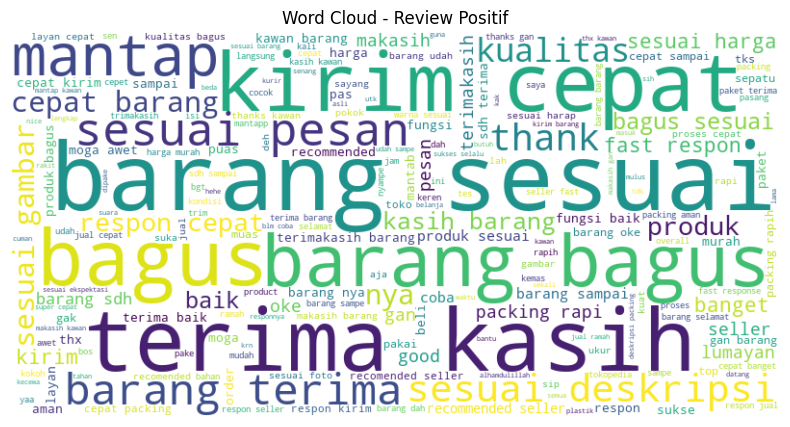

In [117]:
# Word Cloud untuk review positif
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Review Positif')
plt.show()

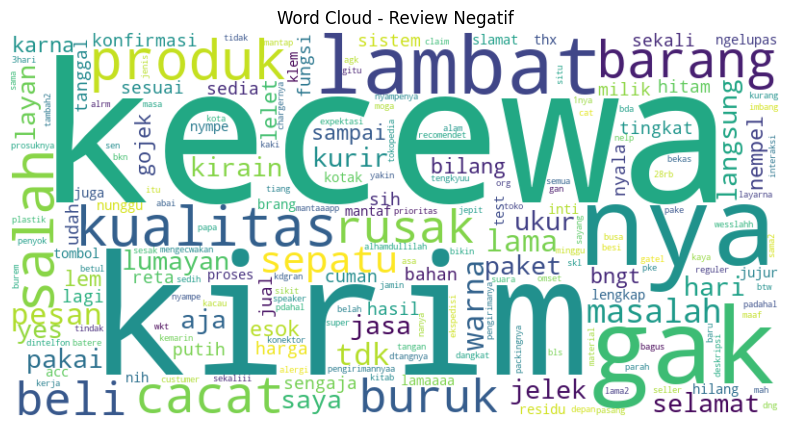

In [118]:
# Word Cloud untuk review negatif
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Review Negatif')
plt.show()

# Summarize

Metode Bart

In [119]:
from transformers import TFBartForConditionalGeneration, BartTokenizer

# Memuat model BART dan tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = TFBartForConditionalGeneration.from_pretrained(model_name)

c:\Users\Dicky Zulfikar\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [120]:
def summarize_text(text, max_length=130):
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=max_length, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

positive_reviews_text = ' '.join(positive_reviews['Review'])

summary_positive = summarize_text(positive_reviews_text)
print("Summarize Review Positive:")
print(summary_positive)

Summarize Review Positive:
thanks  oke barang terima baik barang selamat gan mksih cepat tepat recommended seller barang cepst sampe paking bsgus barang bagus moga laku jua tolong kirim pos paket terima  baik terimakasih trima gan trimakasaih sesuai harap  product.


Metode BERT

In [124]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import nltk

nltk.download('punkt')

# Load BART model dan tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

def summarize_text(text, max_length=130):
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=max_length, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def get_sentence_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        # Mendapatkan output dari encoder
        outputs = model.model.encoder(**inputs)
    # Mengambil embeddings dari output encoder
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()  # Rata-rata untuk semua token

positive_reviews_text = ' '.join(positive_reviews['Review'])
summary_positive = summarize_text(positive_reviews_text)
sentences = nltk.sent_tokenize(summary_positive)

sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
embeddings = np.array([get_sentence_embedding(sentence) for sentence in sentences])

similarity_matrix = cosine_similarity(embeddings)
top_sentence_indices = np.argsort(similarity_matrix.sum(axis=1))[::-1][:3]  # Ambil 3 kalimat teratas
summary = ' '.join(np.array(sentences)[top_sentence_indices])

print("Ringkasan:")
print(summary)


[nltk_data] Downloading package punkt to C:\Users\Dicky
[nltk_data]     Zulfikar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Ringkasan:
thanks  oke barang terima baik barang selamat gan mksih cepat tepat recommended seller barang cepst sampe paking bsgus barang bagus moga laku jua tolong kirim pos paket terima  baik terimakasih trima gan trimakasaih sesuai harap  product.
